In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
df = pd.read_csv("/work/app/data/input/filtered_result.csv")
df["‰ºùÁ•®Êó•‰ªò"] = pd.to_datetime(df["‰ºùÁ•®Êó•‰ªò"], format="%Y-%m-%d", errors="coerce")
df

‰ºùÁ•®Êó•‰ªò    Ê≠£Âë≥ÈáçÈáè              ÂìÅÂêç
0      2020-01-06   470.0          Ê∑∑ÂêàÂªÉÊ£ÑÁâ©B
1      2020-01-06   390.0             „Åù„ÅÆ‰ªñ
2      2020-01-06   120.0          Ê∑∑ÂêàÂªÉÊ£ÑÁâ©A
3      2020-01-06  1720.0          Ê∑∑ÂêàÂªÉÊ£ÑÁâ©B
4      2020-01-06   320.0              ÈÅ∏Âà•
...           ...     ...             ...
210744 2025-05-26   350.0          Ê∑∑ÂêàÂªÉÊ£ÑÁâ©A
210745 2025-05-26    20.0       ÔæÄÔΩ≤Ôæî(ÔæéÔΩ≤ÔæôÁÑ°)
210746 2025-05-26   450.0          Ê∑∑ÂêàÂªÉÊ£ÑÁâ©A
210747 2025-05-26   430.0          Ê∑∑ÂêàÂªÉÊ£ÑÁâ©A
210748 2025-05-26   250.0  ËªΩÈáèÁâ©Á≥ªB(ÔΩ∏ÔæûÔæóÔΩΩÔΩ≥ÔΩ∞Ôæô)

[210749 rows x 3 columns]

In [4]:
# === ÂøÖË¶Å„Å™„É©„Ç§„Éñ„É©„É™ ===
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import jpholiday
from lightgbm import early_stopping, log_evaluation

# === Ë£úÂä©Èñ¢Êï∞ ===

# --- Á•ùÊó•„Éï„É©„Ç∞Âà§ÂÆöÈñ¢Êï∞ ---
def make_holiday_flag(date):
    return int(jpholiday.is_holiday(date) or date.weekday() >= 5)

# --- ÂìÅÁõÆÂàÜÈ°ûÈñ¢Êï∞ ---
def classify_item(item: str) -> str:
    if "Ê∑∑ÂêàÂªÉÊ£ÑÁâ©A" in item:
        return "Ê∑∑ÂêàA"
    elif "Ê∑∑ÂêàÂªÉÊ£ÑÁâ©B" in item:
        return "Ê∑∑ÂêàB"
    else:
        return "„Åù„ÅÆ‰ªñ"


## „Éá„Éº„ÇøÊï¥ÁêÜ

In [6]:
df = df.copy()
df["‰ºùÁ•®Êó•‰ªò"] = pd.to_datetime(df["‰ºùÁ•®Êó•‰ªò"])

# Á•ùÊó•„Éï„É©„Ç∞„ÅÆ‰ªò‰∏é
df["Á•ùÊó•„Éï„É©„Ç∞"] = df["‰ºùÁ•®Êó•‰ªò"].map(lambda x: int(jpholiday.is_holiday(x)))

# ÊõúÊó•‰ªò‰∏é
df["ÊõúÊó•"] = df["‰ºùÁ•®Êó•‰ªò"].dt.dayofweek

# Á•ùÊó• or Êó•Êõú„ÇíÈô§Â§ñÔºà‚Üí ÂúüÊõú„ÅØÊÆã„ÅôÔºâ
df = df[(df["Á•ùÊó•„Éï„É©„Ç∞"] == 0) & (df["ÊõúÊó•"] != 6)].copy()

# ‰ºùÁ•®Êó•‰ªòÂçò‰Ωç„ÅßÊ≠£Âë≥ÈáçÈáè„Å†„Åë„Çí sum ‚Üí DataFrame „Å´Ê†ºÁ¥ç
df_daily_sum = df.groupby("‰ºùÁ•®Êó•‰ªò")["Ê≠£Âë≥ÈáçÈáè"].sum().reset_index()

# 5‰∏ákg‰ª•‰∏ã„ÅÆÊó•‰ªò„ÇíÈô§Â§ñ
df_daily_sum = df_daily_sum[df_daily_sum["Ê≠£Âë≥ÈáçÈáè"] >= 50000].copy()

# --- Á¢∫Ë™çÁî®Ë°®Á§∫ ---
print(f"‚úÖ ÊÆã„Å£„Åü„Éá„Éº„Çø‰ª∂Êï∞: {len(df_daily_sum)}")
print(f"‚úÖ Êó•‰ªòÁØÑÂõ≤: {df_daily_sum['‰ºùÁ•®Êó•‰ªò'].min()} „Äú {df_daily_sum['‰ºùÁ•®Êó•‰ªò'].max()}")

df_daily_sum

‚úÖ ÊÆã„Å£„Åü„Éá„Éº„Çø‰ª∂Êï∞: 1228
‚úÖ Êó•‰ªòÁØÑÂõ≤: 2020-01-06 00:00:00 „Äú 2025-05-26 00:00:00


‰ºùÁ•®Êó•‰ªò      Ê≠£Âë≥ÈáçÈáè
0    2020-01-06  104910.0
1    2020-01-07  108180.0
2    2020-01-08  105990.0
3    2020-01-09  109640.0
4    2020-01-10  102960.0
...         ...       ...
1227 2025-05-21  117900.0
1228 2025-05-22   89880.0
1229 2025-05-23   86810.0
1230 2025-05-24   95000.0
1231 2025-05-26   85420.0

[1228 rows x 2 columns]

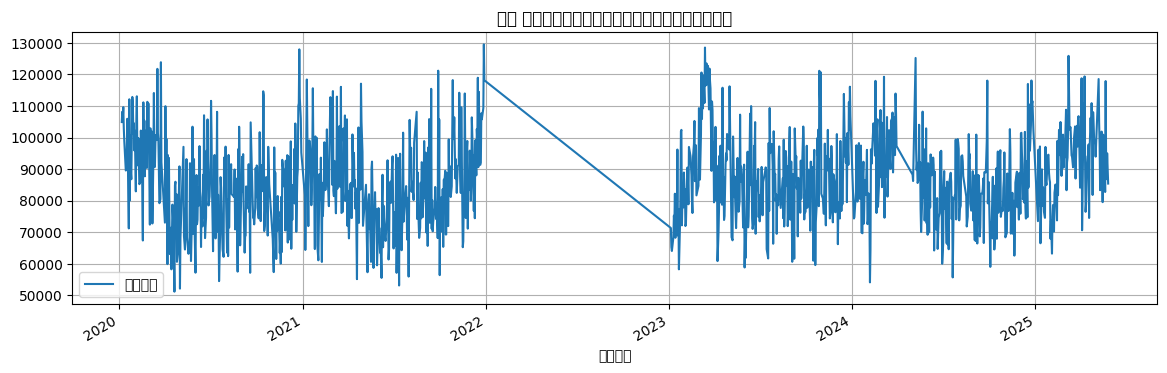

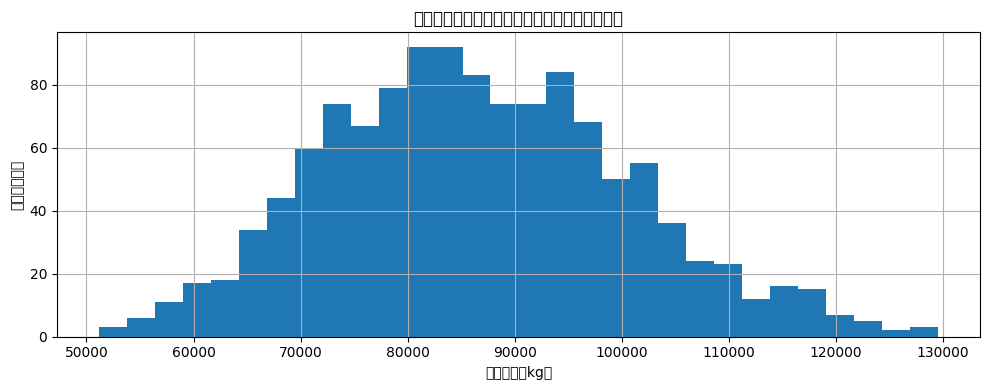

In [7]:

# ÊôÇÁ≥ªÂàó„ÅßÊ≠£Âë≥ÈáçÈáè„Çí„Éó„É≠„ÉÉ„Éà
df_daily_sum.plot(
    x="‰ºùÁ•®Êó•‰ªò",
    y="Ê≠£Âë≥ÈáçÈáè",
    figsize=(14, 4),
    title="Êó•Âà• Ê≠£Âë≥ÈáçÈáè„ÅÆÊé®ÁßªÔºàÁ•ùÊó•„ÉªÊó•ÊõúÈô§Â§ñ„ÄÅÂúüÊõúÂê´„ÇÄÔºâ",
    grid=True
)
# „Éí„Çπ„Éà„Ç∞„É©„É†„ÅßÊ≠£Âë≥ÈáçÈáè„ÅÆÂàÜÂ∏É„ÇíÁ¢∫Ë™ç
plt.figure(figsize=(10, 4))
df_daily_sum["Ê≠£Âë≥ÈáçÈáè"].hist(bins=30)
plt.title("Ê≠£Âë≥ÈáçÈáè„ÅÆÂàÜÂ∏ÉÔºàÁ•ùÊó•„ÉªÊó•ÊõúÈô§Â§ñ„ÄÅÂúüÊõúÂê´„ÇÄÔºâ")
plt.xlabel("Ê≠£Âë≥ÈáçÈáèÔºàkgÔºâ")
plt.ylabel("Êó•Êï∞Ôºà‰ª∂Êï∞Ôºâ")
plt.grid(True)
plt.tight_layout()
plt.show()


## ÁâπÂæ¥ÈáèÁîüÊàê

In [45]:

def add_previous_year_feature(df_pivot: pd.DataFrame) -> pd.DataFrame:
    df_prev_year = df_pivot.copy()
    df_prev_year.index = df_prev_year.index + pd.DateOffset(years=1)
    df_prev_year_sum = df_prev_year.sum(axis=1).to_frame(name="ÂâçÂπ¥ÂêåÊúüÈáçÈáè")
    df_prev_year_sum = df_prev_year_sum.sort_index()

    # ÂÖÉ df_pivot „Å´ merge „Åó„Å¶ "ÂâçÂπ¥ÂêåÊúüÈáçÈáè" „ÇíÂàó„Å®„Åó„Å¶ËøΩÂä†„Åó„Åü DataFrame „ÇíËøî„Åô
    df_current = df_pivot.copy()
    df_current = df_current.sort_index()
    df_current = df_current.merge(
        df_prev_year_sum,
        how="left",
        left_index=True,
        right_index=True
    )

    df_current["ÂâçÂπ¥ÂêåÊúüÈáçÈáè"] = df_current["ÂâçÂπ¥ÂêåÊúüÈáçÈáè"].fillna(0)

    return df_current[["ÂâçÂπ¥ÂêåÊúüÈáçÈáè"]]


def compute_previous_year_ratio(df_pivot: pd.DataFrame) -> pd.DataFrame:
    # ÂâçÂπ¥ÂêåÊúüÈáçÈáè
    df_prev_year_sum = add_previous_year_feature(df_pivot)

    # ÂÖ®‰ΩìÂπ≥ÂùáÊê¨ÂÖ•ÈáèÔºàÂâçÂπ¥„ÅÆ„ÅøÔºâ
    prev_year_dates = df_pivot.index - pd.DateOffset(years=1)
    mask_prev_year = df_pivot.index.isin(prev_year_dates)
    total_prev_year_weight = df_pivot.loc[mask_prev_year].sum(axis=1).mean()

    # ÊØîÁéá = ÂâçÂπ¥ÂêåÊúüÈáçÈáè / ÂâçÂπ¥Âπ≥Âùá
    df_prev_year_sum["ÂâçÂπ¥ÂêåÊúüÊØîÁéá"] = df_prev_year_sum["ÂâçÂπ¥ÂêåÊúüÈáçÈáè"] / total_prev_year_weight
    df_prev_year_sum["ÂâçÂπ¥ÂêåÊúüÊØîÁéá"] = df_prev_year_sum["ÂâçÂπ¥ÂêåÊúüÊØîÁéá"].fillna(0)

    return df_prev_year_sum[["ÂâçÂπ¥ÂêåÊúüÊØîÁéá"]]


def add_holiday_adjacent_flag(dates: pd.Index) -> pd.Series:
    # Á•ùÊó•„Éï„É©„Ç∞Ôºà„ÅÇ„Å™„Åü„ÅÆ make_holiday_flag „Çí‰Ωø„ÅÜÔºâ
    holiday_flags = dates.map(make_holiday_flag).astype(int)

    # ÈÄ£‰ºëÂâçÂæå„Éï„É©„Ç∞ÂàùÊúüÂåñ
    adjacent_flags = np.zeros(len(dates), dtype=int)

    # „É´„Éº„Éó„ÅßÂâçÂæåÂà§ÂÆö
    for i in range(1, len(dates) - 1):
        # ÈÄ£‰ºë‰∏≠„Å™„Çâ1
        if holiday_flags[i] == 1:
            adjacent_flags[i] = 1
        # ÈÄ£‰ºëÂâçÊó•
        elif holiday_flags[i - 1] == 1:
            adjacent_flags[i] = 1
        # ÈÄ£‰ºëÁøåÊó•
        elif holiday_flags[i + 1] == 1:
            adjacent_flags[i] = 1

    return pd.Series(adjacent_flags, index=dates, name="ÈÄ£‰ºëÂâçÂæå„Éï„É©„Ç∞")

def add_month_start_end_flags(dates: pd.Index) -> pd.DataFrame:
    df = pd.DataFrame(index=dates)
    df["day"] = dates.day
    df["days_in_month"] = dates.days_in_month

    df["ÊúàÂàù„Éï„É©„Ç∞"] = (df["day"] <= 3).astype(int)
    df["ÊúàÊú´„Éï„É©„Ç∞"] = (df["days_in_month"] - df["day"] <= 2).astype(int)

    return df[["ÊúàÂàù„Éï„É©„Ç∞", "ÊúàÊú´„Éï„É©„Ç∞"]]


### ÂÆüÈñ¢Êï∞

In [ ]:
def prepare_features(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series]:
      # --- ÁâπÂæ¥Èáè‰ΩúÊàê ---
    df_feat = df_daily_sum.copy()
    df_feat["ÊõúÊó•"] = df_feat["‰ºùÁ•®Êó•‰ªò"].dt.dayofweek
    df_feat["Êúà"] = df_feat["‰ºùÁ•®Êó•‰ªò"].dt.month
    df_feat["ÂâçÊó•Ê≠£Âë≥ÈáçÈáè"] = df_feat["Ê≠£Âë≥ÈáçÈáè"].shift(1)
    df_feat["ÁøåÊó•Ê≠£Âë≥ÈáçÈáè"] = df_feat["Ê≠£Âë≥ÈáçÈáè"].shift(-1)

    # dropna
    df_feat = df_feat.dropna().reset_index(drop=True)

    # X, y
    X = df_feat.drop(columns=["‰ºùÁ•®Êó•‰ªò", "ÁøåÊó•Ê≠£Âë≥ÈáçÈáè"])
    y = df_feat["ÁøåÊó•Ê≠£Âë≥ÈáçÈáè"]

    return X, y, df_feat

## „É¢„Éá„É´Âá¶ÁêÜ

In [47]:

# --- FoldÂçò‰Ωç„ÅÆÂ≠¶Áøí„ÉªË©ï‰æ° ---
def train_and_evaluate_fold(fold, X_train, X_test, y_train, y_test):
    # --- LightGBM„Éá„Éº„Çø„Çª„ÉÉ„Éà ---
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)
    
    # --- „Éë„É©„É°„Éº„Çø ---
    params = {
        "objective": "regression",
        "metric": "mae",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "learning_rate": 0.05,
        "num_leaves": 31,
        "max_depth": 7,
        "min_data_in_leaf": 20,
        "feature_fraction": 0.8,
        "bagging_fraction": 0.8,
        "bagging_freq": 5,
    }
    
    # --- Â≠¶Áøí ---
    model = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_eval],
        num_boost_round=2000,
        callbacks=[
            early_stopping(stopping_rounds=100),
            log_evaluation(period=100),
        ],
    )
    
    # --- Â≠¶Áøí„Éá„Éº„ÇøÂÅ¥„ÅÆË©ï‰æ° ---
    y_train_pred = model.predict(X_train)
    r2_train = r2_score(y_train, y_train_pred)
    
    # --- „ÉÜ„Çπ„Éà„Éá„Éº„ÇøÂÅ¥„ÅÆË©ï‰æ° ---
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2_test = r2_score(y_test, y_pred)
    
    # --- ÁµêÊûúË°®Á§∫ ---
    print(f"\nüìÇ Fold {fold+1}")
    print(f"üìä MAE:       {mae:.2f} kg")
    print(f"üìä Train R¬≤:  {r2_train:.4f}")
    print(f"üìä Test  R¬≤:  {r2_test:.4f}")
    
    return mae, r2_train, r2_test

# --- FoldÂπ≥ÂùáÁµêÊûúÂá∫Âäõ ---
def print_fold_summary(mae_list, r2_train_list, r2_test_list):
    print("\n‚úÖ ÂÖ®FoldÂπ≥ÂùáMAE: {:.2f} kg".format(np.mean(mae_list)))
    print("‚úÖ ÂÖ®FoldÂπ≥ÂùáTrain R¬≤: {:.4f}".format(np.mean(r2_train_list)))
    print("‚úÖ ÂÖ®FoldÂπ≥ÂùáTest  R¬≤: {:.4f}".format(np.mean(r2_test_list)))
    print("")


## „É°„Ç§„É≥Âá¶ÁêÜ

In [48]:

# === „É°„Ç§„É≥Âá¶ÁêÜ ===

# --- „Éá„Éº„ÇøË™≠„ÅøËæº„ÅøÔºà„Åì„Åì„ÅØ„ÅÇ„Å™„Åü„ÅÆÂÖÉ„ÅÆ df „ÇíÁî®ÊÑè„Åó„Å¶„Åä„ÅèÔºâ ---
# ‰æã: df = pd.read_csv("your_data.csv")
# ‰ªäÂõû„ÅØÊó¢„Å´ df „ÅåÂÆöÁæ©Ê∏à„Åø„Å®„Åó„Å¶ÈÄ≤„ÇÅ„Åæ„Åô

X, y ,df_feat  = prepare_features(df)

# --- TimeSeriesSplitË®≠ÂÆö ---
tscv = TimeSeriesSplit(n_splits=5)

# --- fold„Åî„Å®„ÅÆË©ï‰æ°Áî® ---
fold_mae_list = []
fold_r2_train_list = []
fold_r2_test_list = []

# --- „É¢„Éá„É´„É´„Éº„Éó ---
for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    mae, r2_train, r2_test = train_and_evaluate_fold(fold, X_train, X_test, y_train, y_test)
    
    fold_mae_list.append(mae)
    fold_r2_train_list.append(r2_train)
    fold_r2_test_list.append(r2_test)

# --- ÁµêÊûú„Åæ„Å®„ÇÅË°®Á§∫ ---
print_fold_summary(fold_mae_list, fold_r2_train_list, fold_r2_test_list)


Training until validation scores don't improve for 100 rounds
[100]	training's l1: 6907.56	valid_1's l1: 11327.9
Early stopping, best iteration is:
[32]	training's l1: 8799.66	valid_1's l1: 11045.5

üìÇ Fold 1
üìä MAE:       11045.45 kg
üìä Train R¬≤:  0.4783
üìä Test  R¬≤:  0.1202
Training until validation scores don't improve for 100 rounds
[100]	training's l1: 6685.06	valid_1's l1: 11778.5
Early stopping, best iteration is:
[12]	training's l1: 10317.3	valid_1's l1: 11275.9

üìÇ Fold 2
üìä MAE:       11275.85 kg
üìä Train R¬≤:  0.2724
üìä Test  R¬≤:  0.0776
Training until validation scores don't improve for 100 rounds
[100]	training's l1: 6689.44	valid_1's l1: 10065.1
Early stopping, best iteration is:
[21]	training's l1: 9487.11	valid_1's l1: 9727.28

üìÇ Fold 3
üìä MAE:       9727.28 kg
üìä Train R¬≤:  0.3677
üìä Test  R¬≤:  0.1894
Training until validation scores don't improve for 100 rounds
[100]	training's l1: 6806.69	valid_1's l1: 9854.39
Early stopping, best iterat

‚úÖ „Éá„Éº„Çø‰ª∂Êï∞: 1233
‚úÖ Êó•‰ªòÁØÑÂõ≤: 2020-01-07 00:00:00 „Äú 2025-05-24 00:00:00

‚úÖ ÊõúÊó•„Åî„Å®„ÅÆ‰ª∂Êï∞Ôºà0=ÊúàÊõú„ÄÅ6=Êó•ÊõúÔºâ
ÊõúÊó•
0    190
1    203
2    213
3    206
4    212
5    209
Name: count, dtype: int64

‚úÖ ÁøåÊó•ÂêàË®à describe():
count      1233.000000
mean      86377.858881
std       14304.365307
min       21820.000000
25%       76270.000000
50%       85730.000000
75%       95890.000000
max      129520.000000
Name: ÁøåÊó•ÂêàË®à, dtype: float64


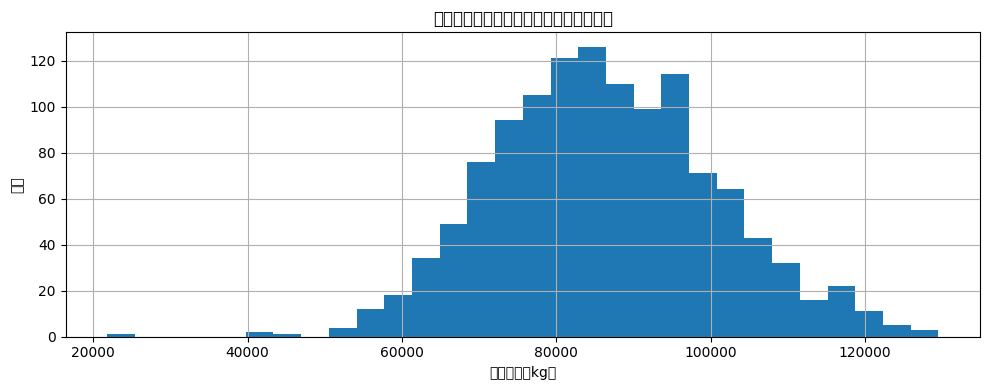

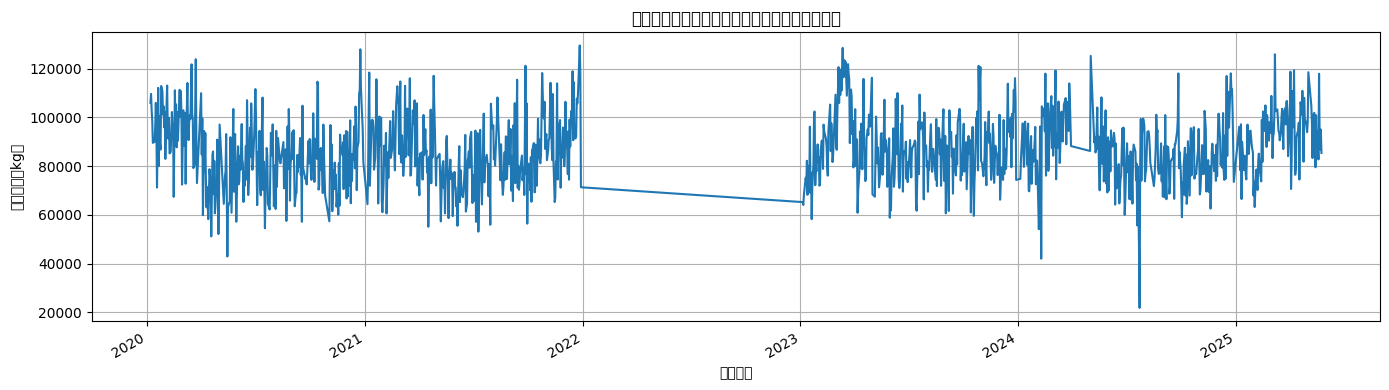

In [49]:
# === ‚ë† df_feat „ÅÆ‰ª∂Êï∞Á¢∫Ë™ç ===
print("‚úÖ „Éá„Éº„Çø‰ª∂Êï∞:", len(df_feat))
print("‚úÖ Êó•‰ªòÁØÑÂõ≤:", df_feat["‰ºùÁ•®Êó•‰ªò"].min(), "„Äú", df_feat["‰ºùÁ•®Êó•‰ªò"].max())

# === ‚ë° ÊõúÊó•„Åî„Å®„ÅÆ‰ª∂Êï∞Á¢∫Ë™ç ===
print("\n‚úÖ ÊõúÊó•„Åî„Å®„ÅÆ‰ª∂Êï∞Ôºà0=ÊúàÊõú„ÄÅ6=Êó•ÊõúÔºâ")
print(df_feat["ÊõúÊó•"].value_counts().sort_index())

# === ‚ë¢ ÁøåÊó•ÂêàË®à„ÅÆÂàÜÂ∏ÉÁ¢∫Ë™ç ===
print("\n‚úÖ ÁøåÊó•ÂêàË®à describe():")
print(df_feat["ÁøåÊó•ÂêàË®à"].describe())

# ÁøåÊó•ÂêàË®à„ÅÆ„Éí„Çπ„Éà„Ç∞„É©„É†ÔºàÂàÜÂ∏ÉÁ¢∫Ë™çÔºâ
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
df_feat["ÁøåÊó•ÂêàË®à"].hist(bins=30)
plt.title("ÁøåÊó•ÂêàË®à„ÅÆÂàÜÂ∏ÉÔºà‰ºëÊó•„ÉªÊó•Êõú„Ç´„ÉÉ„ÉàÂæåÔºâ")
plt.xlabel("ÁøåÊó•ÂêàË®àÔºàkgÔºâ")
plt.ylabel("‰ª∂Êï∞")
plt.grid(True)
plt.tight_layout()
plt.show()

# === ‚ë£ Êê¨ÂÖ•ÈáèÔºàÁøåÊó•ÂêàË®àÔºâ vs Êó•‰ªò„ÅÆÊé®ÁßªÔºàÊôÇÁ≥ªÂàóÁ¢∫Ë™çÔºâ ===
df_feat.set_index("‰ºùÁ•®Êó•‰ªò")["ÁøåÊó•ÂêàË®à"].plot(figsize=(14, 4), title="ÁøåÊó•ÂêàË®à„ÅÆÊôÇÁ≥ªÂàóÊé®ÁßªÔºà‰ºëÊó•„ÉªÊó•Êõú„Ç´„ÉÉ„ÉàÂæåÔºâ", grid=True)
plt.ylabel("ÁøåÊó•ÂêàË®àÔºàkgÔºâ")
plt.tight_layout()
plt.show()
